In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import *
import glob
import scipy 
from datetime import datetime as dt
import sklearn
sns.style = 'darkgrid'

In [2]:
positive_affect = pd.read_json('dataset/dataset/EMA/response/PAM/PAM_u00.json')

In [3]:
positive_affect

,picture_idx,resp_time
0,7,2013-03-24 08:45:48
1,11,2013-03-24 20:15:56
2,7,2013-03-24 08:40:30
3,8,2013-03-24 08:45:42
4,7,2013-03-26 02:21:15
...,...,...
385,7,2013-06-06 05:35:39
386,7,2013-06-07 19:46:18
387,10,2013-06-26 23:09:43
388,7,2013-06-26 23:18:04


In [4]:
def combine_daily_emas(ema_name): 
    """
    input: ema_name -- name of the ema we're looking at
    output: dataframe containing the data from the desired ema compiled for all uids
    """
    # list of all the desired ema's 
    all_emas = glob.glob('dataset/dataset/EMA/response/' + ema_name + '/' + ema_name +'_*.json')
    # index to start the uid
    uid_start = len('dataset/dataset/EMA/response/' + ema_name + '/' + ema_name +'_')
    # this is where we'll compile the data
    total_ema_data = pd.DataFrame()
    # loops through all the ema data
    for ema in all_emas: 
        # the uid is the three characters starting at uid_start index
        uid = ema[uid_start:uid_start + 3]
        # read the data
        ema_data = pd.read_json(ema)
        # keep track of day and day of week
        try:
            ema_data['doy'] = ema_data['resp_time'].dt.dayofyear 
            ema_data['day of week'] = ema_data['resp_time'].dt.dayofweek
            ema_data = ema_data.groupby('doy').mean()
            ema_data['day'] = ema_data.index
        except:
            # in this case there is an empty dataframe for this uid
            continue
        
        # keep track of uids
        ema_data['uid'] = uid
        
        # compile the data
        total_ema_data = total_ema_data.append(ema_data)

    return total_ema_data    

In [5]:
def merge_EMA(EMA_list): 
    """
    input: EMA_list -- contains a list of tuples, each tuple containing the name of an EMA and the name of a desired column
    in that EMA.
    output: a dataframe combining all those EMA's for every user. 
    """
    initialized = False
    for tup in EMA_list: 
        ema = tup[0]
        col = tup[1]
        ema_for_all_students = combine_daily_emas(ema)
        
        relevant_columns = ema_for_all_students[[col, 'day', 'day of week', 'uid']]
        
        if initialized is False: 
            initialized = True
            overall_merge = relevant_columns
        else: 
            overall_merge = overall_merge.merge(relevant_columns, on = ['day', 'day of week', 'uid'], how = 'inner')
    
    return overall_merge

In [6]:
def most_responded_emas():
    """
    output:  dictionary of (ema name: number of responses) where each key is an ema and the value is the number 
    of days it was responded to 
    """
    ema_lengths = {}
    for file in glob.glob('dataset/dataset/EMA/response/*'): 
        ema = file[len('dataset/dataset/EMA/response/'):]
        total_emas = combine_daily_emas(ema)
        ema_lengths[ema] = total_emas.shape[0]
    return ema_lengths

In [7]:
#most_responded_emas()

In [8]:
mood_and_PAM = merge_EMA([('PAM', 'picture_idx'), ('Stress', 'level'), ('Social', 'number')])

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [9]:
mood_and_PAM = mood_and_PAM.dropna()
mood_and_PAM['weekend'] = mood_and_PAM['day of week'] > 4
mood_and_PAM_u00 = mood_and_PAM[mood_and_PAM['uid'] == 'u01']
mood_and_PAM_u00

,picture_idx,day,day of week,uid,level,number,weekend
609,7.500000,86,2.0,u01,4.0,3.333333,False
610,12.750000,88,4.0,u01,1.0,4.000000,False
611,9.600000,89,5.0,u01,3.0,3.000000,True
612,11.333333,90,6.0,u01,1.0,4.000000,True
613,11.500000,93,2.0,u01,1.0,2.000000,False
614,10.333333,95,4.0,u01,4.0,4.000000,False
615,10.500000,96,5.0,u01,4.5,4.000000,True
616,13.666667,97,6.0,u01,1.0,3.000000,True
617,9.400000,100,2.0,u01,1.5,3.000000,False
618,8.000000,102,4.0,u01,1.0,2.000000,False


In [10]:
from sklearn.decomposition import PCA
def plot_pca(EMA_df, feature_columns, target_column):
    """
    given input features plots a principal component analysis (first two components)
    """
    # keep the first two principal components of the data
    features = EMA_df[feature_columns].values
    pca = PCA(n_components=2)
    pg_transformed = pca.fit_transform(features)
    pg_df = pd.DataFrame(data = pg_transformed, columns = ['PC_1', 'PC_2'])
    
    # print relevant results
    print("features: ", feature_columns)
    print("component 1 weights: ", pca.components_[0])
    print("component 2 weights: ", pca.components_[1])
    print("variance explained: ", pca.explained_variance_ratio_)
    
    # make a plot of the principal components
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(pg_transformed[:,0][EMA_df[target_column] == True], 
               pg_transformed[:,1][EMA_df[target_column] == True], 
               label = target_column ,marker ='o')
    
    ax.scatter(pg_transformed[:,0][EMA_df[target_column] == False], 
               pg_transformed[:,1][EMA_df[target_column] == False], 
               label = 'not {}'.format(target_column), marker = 'x')
    
    plt.legend(loc='upper right')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    return pg_transformed

In [11]:
def convert_stress(level):
    """
    converts input stress level from the scale above into a more usable scale with 1 being feeling great 
    and 5 being stressed out.
    """
    # little stress = 3/5 stressed
    if level == 1: 
        return 3
    # definitely stressed = 4/5
    if level == 2:
        return 4
    # stressed out = 5/5
    if level == 3:
        return 5
    # feeling good = 2/5
    if level == 4: 
        return 2
    # feeling great = 1/5 
    if level == 5:
        return 1
    else:
        return 0

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
def stress_feature_importance(uid): 
    """
    ranks the feature importance of five different sensors: activity inference, conversation duration, 
    bluetooth colocations, darkness, and location variance based on how important they are at predicting stress for a 
    given day. 
    """
    stress = pd.read_json('dataset/dataset/EMA/response/stress/Stress_' + uid + '.json')
    stress = stress[['location', 'resp_time', 'level']]
    stress = stress.dropna()
    stress['level'] = stress['level'].apply(convert_stress)
    stress['day'] = stress['resp_time'].dt.dayofyear
    stress = stress.groupby('day').mean()
    # since stress levels are discrete, we want to take the nearest overall stress level for the day 
    stress = stress.apply(lambda x: round(x))
    stress['doy'] = stress.index
    
    # compiling features (sensors)
    activity = pd.read_csv('dataset/dataset/sensing/activity/activity_' + uid + '.csv')
    activity['day'] = pd.to_datetime(activity['timestamp'], unit = 's').dt.dayofyear
    daily_activity = activity.groupby('day').mean()
    
    conversation = pd.read_csv('dataset/dataset/sensing/conversation/conversation_' + uid + '.csv')
    conversation['day'] = pd.to_datetime(conversation['start_timestamp'], unit = 's').dt.dayofyear
    conversation['convo duration'] = conversation[' end_timestamp'] - conversation['start_timestamp']
    conversation = conversation.groupby('day').sum()
    
    bluetooth = pd.read_csv('dataset/dataset/sensing/bluetooth/bt_' + uid + '.csv')
    bluetooth['day'] = pd.to_datetime(bluetooth['time'], unit = 's').dt.dayofyear
    bluetooth = bluetooth.groupby('day').count()
    bluetooth['number colocations'] = bluetooth['time']
        
    darkness = pd.read_csv('dataset/dataset/sensing/dark/dark_' + uid + '.csv')
    darkness['day'] = pd.to_datetime(darkness['start'], unit = 's').dt.dayofyear
    darkness['dark duration'] = darkness['end'] - darkness['start']
    darkness = darkness.groupby('day').sum()
    
    wifi_locations = pd.read_csv('dataset/dataset/sensing/wifi_location/wifi_location_' + uid + '.csv')
    wifi_locations.reset_index(inplace = True)
    wifi_locations.columns = ("timestamp", "location", "null")
    wifi_locations = wifi_locations.drop("null", 1)
    wifi_locations['day'] = pd.to_datetime(wifi_locations['timestamp'], unit = 's').dt.dayofyear
    wifi_locations = pd.DataFrame(wifi_locations.groupby('day')['location'].unique())
    wifi_locations['unique locations'] = wifi_locations['location'].apply(lambda x: len(x))
    
    features_list = [(daily_activity, ' activity inference'), (conversation, 'convo duration'), 
                     (darkness, 'dark duration'), (bluetooth, 'number colocations'), 
                     (wifi_locations, 'unique locations')]
    data = stress
    for feat in features_list: 
        print(data.shape)
        data = data.merge(feat[0][[feat[1]]], 
                                left_on = 'doy', right_on = 'day', how = 'inner')
        
    
    features_names = [' activity inference', 'convo duration', 'dark duration',
                     'number colocations', 'unique locations']
    features = data[features_names].values
    
    target = data['level'].values
    
    feat_import = model_importance(RandomForestClassifier(), features, target, features_names)
    
    return data.shape

In [13]:
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut

def model_importance(model, features, target, features_names): 
    """
    given input features and targets (labels), a random forest model is created to 
    """
    n_features = features.shape[1]
    print(cross_val_score(model, features, target, cv = 5))
    model.fit(features, target)
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), features_names)
    plt.xlabel('feature importance')
    return model.feature_importances_

(35, 2)
(35, 3)
(35, 4)
(32, 5)
(32, 6)
[0.75       0.85714286 0.85714286 0.8        1.        ]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/

(32, 7)

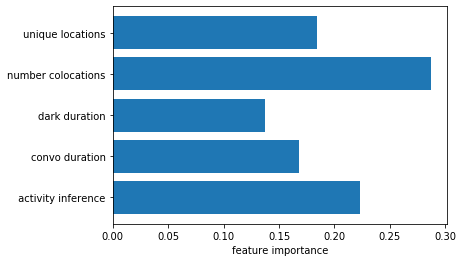

In [14]:
stress_feature_importance('u17')

In [15]:
bluetooth = pd.read_csv('dataset/dataset/sensing/bluetooth/bt_' + 'u00' + '.csv')

In [16]:
#bluetooth

In [17]:
bluetooth['day'] = pd.to_datetime(bluetooth['time'], unit = 's').dt.dayofyear
bluetooth = bluetooth.groupby('day').count()

In [18]:
def stress_feature_importance(uid): 
    """
    ranks the feature importance of five different sensors: activity inference, conversation duration, 
    bluetooth colocations, darkness, and location variance based on how important they are at predicting stress for a 
    given day. 
    """
    stress = pd.read_json('dataset/dataset/EMA/response/stress/Stress_' + uid + '.json')
    stress = stress[['location', 'resp_time', 'level']]
    stress = stress.dropna()
    stress['level'] = stress['level'].apply(convert_stress)
    stress['day'] = stress['resp_time'].dt.dayofyear
    stress = stress.groupby('day').mean()
    # since stress levels are discrete, we want to take the nearest overall stress level for the day 
    stress = stress.apply(lambda x: round(x))
    stress['doy'] = stress.index
    
    # compiling features (sensors)
    activity = pd.read_csv('dataset/dataset/sensing/activity/activity_' + uid + '.csv')
    activity['day'] = pd.to_datetime(activity['timestamp'], unit = 's').dt.dayofyear
    daily_activity = activity.groupby('day').mean()
    
    conversation = pd.read_csv('dataset/dataset/sensing/conversation/conversation_' + uid + '.csv')
    conversation['day'] = pd.to_datetime(conversation['start_timestamp'], unit = 's').dt.dayofyear
    conversation['start hour'] = pd.to_datetime(conversation['start_timestamp'], unit='s').dt.hour
    conversation['end hour'] = pd.to_datetime(conversation[' end_timestamp'], unit='s').dt.hour
    conversation['convo_duration'] = conversation[' end_timestamp'] - conversation['start_timestamp']
    conversation['epoch'] = list(zip(conversation['start hour'], conversation['end hour']))
    def epoch(times_tuple):        
        start = times_tuple[0]
        end = times_tuple[1]
        
        if (start and end) > 10 and (start and end) <=18:
            return 'Day'
        elif (start and end) >0 and (start and end) <=10:
            return 'Night'
        elif (start and end) >18:
            return 'Evening'
    conversation['epoch'] = conversation['epoch'].apply(epoch)
    convo_day = conversation[conversation['epoch']=='Day']
    convo_eve = conversation[conversation['epoch']=='Evening']
    convo_nig = conversation[conversation['epoch']=='Night']
    convo_freq_day = convo_nig.groupby('day').convo_duration.count()
    convo_freq_eve = convo_eve.groupby('day').convo_duration.count()
    convo_freq_nig = convo_nig.groupby('day').convo_duration.count()
    convo_freq = conversation.groupby('day').convo_duration.count()
    
    #conversation = conversation.groupby('day').sum()
    #conversation = conversation.groupby('epoch').day.count()
    
    
    bluetooth = pd.read_csv('dataset/dataset/sensing/bluetooth/bt_' + uid + '.csv')
    bluetooth['day'] = pd.to_datetime(bluetooth['time'], unit = 's').dt.dayofyear
    bluetooth = bluetooth.groupby('day').count()
    bluetooth['number colocations'] = bluetooth['time']
        
    darkness = pd.read_csv('dataset/dataset/sensing/dark/dark_' + uid + '.csv')
    darkness['day'] = pd.to_datetime(darkness['start'], unit = 's').dt.dayofyear
    darkness['dark duration'] = darkness['end'] - darkness['start']
    darkness = darkness.groupby('day').sum()
    
    wifi_locations = pd.read_csv('dataset/dataset/sensing/wifi_location/wifi_location_' + uid + '.csv')
    wifi_locations.reset_index(inplace = True)
    wifi_locations.columns = ("timestamp", "location", "null")
    wifi_locations = wifi_locations.drop("null", 1)
    wifi_locations['day'] = pd.to_datetime(wifi_locations['timestamp'], unit = 's').dt.dayofyear
    wifi_locations = pd.DataFrame(wifi_locations.groupby('day')['location'].unique())
    wifi_locations['unique locations'] = wifi_locations['location'].apply(lambda x: len(x))
    
    features_list = [(daily_activity, ' activity inference'), (darkness, 'dark duration'), (bluetooth, 'number colocations'), (convo_freq, 'convo_duration'), (convo_freq_day, 'convo_duration'), (convo_freq_nig, 'convo_duration'), (wifi_locations, 'unique locations')]
    #data = stress
    #for feat in features_list: 
        #print(data.shape)
        #data = data.merge(feat[0][[feat[1]]], 
                                #left_on = 'doy', right_on = 'day', how = 'inner')
        
    
    #features_names = [' activity inference', 'dark duration',
                     #'number colocations', 'unique locations']
    #'convo duration'
    #features = data[features_names].values
    
   # target = data['level'].values
    
    #feat_import = model_importance(RandomForestClassifier(), features, target, features_names)
    
    return features_list

In [19]:
pam = pd.read_json('dataset/dataset/EMA/response/PAM/PAM_' + 'u00' + '.json')

In [20]:
pam['day'] = pd.to_datetime(pam['resp_time'], unit='s').dt.dayofyear
pam = pam.groupby('day').mean()

In [21]:
pam

,picture_idx
day,
83,9.125000
84,8.250000
85,9.833333
86,8.333333
87,6.333333
...,...
156,13.000000
157,7.000000
158,7.000000


In [22]:
def pam(uid): 
    """
    ranks the feature importance of five different sensors: activity inference, conversation duration, 
    bluetooth colocations, darkness, and location variance based on how important they are at predicting stress for a 
    given day. 
    """
    pam = pd.read_json('dataset/dataset/EMA/response/PAM/PAM_' + uid + '.json')
    #pam = pam[['location', 'resp_time', 'level']]
    pam = pam.dropna()
    #stress['level'] = stress['level'].apply(convert_stress)
    pam['day'] = pam['resp_time'].dt.dayofyear
    pam = pam.groupby('day').mean()
    # since stress levels are discrete, we want to take the nearest overall stress level for the day 
    pam = pam.apply(lambda x: round(x))
    pam['doy'] = pam.index
    
    # compiling features (sensors)
    activity = pd.read_csv('dataset/dataset/sensing/activity/activity_' + uid + '.csv')
    activity['day'] = pd.to_datetime(activity['timestamp'], unit = 's').dt.dayofyear
    daily_activity = activity.groupby('day').mean()
    
    conversation = pd.read_csv('dataset/dataset/sensing/conversation/conversation_' + uid + '.csv')
    conversation['day'] = pd.to_datetime(conversation['start_timestamp'], unit = 's').dt.dayofyear
    conversation['start hour'] = pd.to_datetime(conversation['start_timestamp'], unit='s').dt.hour
    conversation['end hour'] = pd.to_datetime(conversation[' end_timestamp'], unit='s').dt.hour
    conversation['convo_duration'] = conversation[' end_timestamp'] - conversation['start_timestamp']
    conversation['epoch'] = list(zip(conversation['start hour'], conversation['end hour']))
    def epoch(times_tuple):        
        start = times_tuple[0]
        end = times_tuple[1]
        
        if (start and end) > 10 and (start and end) <=18:
            return 'Day'
        elif (start and end) >0 and (start and end) <=10:
            return 'Night'
        elif (start and end) >18:
            return 'Evening'
    
    conversation['epoch'] = conversation['epoch'].apply(epoch)
    conversation['day epoch'] = conversation['epoch']=='Day'
    conversation['eve epoch'] = conversation['epoch']=='Evening'
    conversation['night epoch'] = conversation['epoch']=='Night'
    conversation = conversation.replace(False, np.nan)
    #convo_day = conversation[conversation['epoch']=='Day']
    #convo_eve = conversation[conversation['epoch']=='Evening']
    #convo_nig = conversation[conversation['epoch']=='Night']
    #convo_freq_day = convo_nig.groupby('day').convo_duration.count()
    #convo_freq_eve = convo_eve.groupby('day').convo_duration.count()
    #convo_freq_nig = convo_nig.groupby('day').convo_duration.count()
    #convo_freq = conversation.groupby('day').convo_duration.count()
    conversation = conversation.groupby('day').count()
    #conversation['num day epoch'] = list(convo_freq_day)
    #conversation['num night epoch'] = list(convo_freq_nig)
    
    #conversation = conversation.groupby('day').sum()
    #conversation = conversation.groupby('epoch').day.count()
    
    
    bluetooth = pd.read_csv('dataset/dataset/sensing/bluetooth/bt_' + uid + '.csv')
    bluetooth['day'] = pd.to_datetime(bluetooth['time'], unit = 's').dt.dayofyear
    bluetooth = bluetooth.groupby('day').count()
    bluetooth['number colocations'] = bluetooth['time']
        
    darkness = pd.read_csv('dataset/dataset/sensing/dark/dark_' + uid + '.csv')
    darkness['day'] = pd.to_datetime(darkness['start'], unit = 's').dt.dayofyear
    darkness['dark duration'] = darkness['end'] - darkness['start']
    darkness = darkness.groupby('day').sum()
    
    wifi_locations = pd.read_csv('dataset/dataset/sensing/wifi_location/wifi_location_' + uid + '.csv')
    wifi_locations.reset_index(inplace = True)
    wifi_locations.columns = ("timestamp", "location", "null")
    wifi_locations = wifi_locations.drop("null", 1)
    wifi_locations['day'] = pd.to_datetime(wifi_locations['timestamp'], unit = 's').dt.dayofyear
    wifi_locations = pd.DataFrame(wifi_locations.groupby('day')['location'].unique())
    wifi_locations['unique locations'] = wifi_locations['location'].apply(lambda x: len(x))
    
    features_list = [(daily_activity, ' activity inference'), (darkness, 'dark duration'), (bluetooth, 'number colocations'), (conversation, 'convo_duration'), (conversation, 'day epoch'), (conversation, 'night epoch'), (wifi_locations, 'unique locations')]
    data = pam
    for feat in features_list: 
        #print(data.shape)
        data = data.merge(feat[0][[feat[1]]], 
                                left_on = 'doy', right_on = 'day', how = 'inner')
        
    
    features_names = [' activity inference', 'dark duration',
                     'number colocations', "convo_duration", 'day epoch', 'night epoch', 'unique locations']
    features = data[features_names].values
    
    target = data['picture_idx'].values
    
    #feat_import = model_importance(RandomForestClassifier(), features, target, features_names)
    
    return data


In [26]:
dataframe = pam('u00')

In [28]:
def add_location_feat(data, uid):
    wifi_locations = pd.read_csv('dataset/dataset/sensing/wifi_location/wifi_location_' + uid + '.csv')
    wifi_locations.reset_index(inplace = True)
    wifi_locations.columns = ("timestamp", "location", "null")
    wifi_locations = wifi_locations.drop("null", 1)
    wifi_locations['day'] = pd.to_datetime(wifi_locations['timestamp'], unit = 's').dt.dayofyear
    return wifi_locations
wifi = add_location_feat(dataframe, 'u00')

In [29]:
wifi.head()

,timestamp,location,day
0,1364384540,in[east-wheelock],86
1,1364384555,in[east-wheelock],86
2,1364384579,in[east-wheelock],86
3,1364384641,in[east-wheelock],86
4,1364384659,in[east-wheelock],86


In [94]:
def shift_counter_id(data):
    shift_num = 0
    #counter = 0
    list_shift_num = []
    for i in range(0, len(data)):
        #if data.location[i] == data.location[i+1]:
        try: 
            if data.location[i] == data.location[i+1] and data.day[i] == data.day[i+1]:
            #data.index[i] == (data.index[i+1] - 1)
                shift_num += 1
            else:
                list_shift_num.append(shift_num)
                shift_num = 0
        except:
            list_shift_num.append(shift_num)
            shift_num = 0
    return list_shift_num
list_shifts = shift_counter_id(wifi)
def shifts_only(list1):
    shifts_only_list = []
    for i in list1:
        if i != 0:
            shifts_only_list.append(i)
    return shifts_only_list

#This list is a list of non-zero shift numbers.
list_shifts = shifts_only(list_shifts)

def get_sums(list1):
    list_sums_b = []
    for i in range(0,len(list1)+1):
        new_list = list1[:i]
        sums = sum(new_list)
        list_sums_b.append(sums)
    return list_sums_b
list_sums_before = get_sums(list_shifts)

In [107]:
def time_delta(data, list_shift_num):
    time_deltas = []
    location = []
    start_time = []
    uid = []
    for i in range(0, len(list_shift_num)):
        if i == 0:
            time_deltas.append(wifi['timestamp'][list_shift_num[i]] - wifi['timestamp'][0])
            #uid.append(data.uid[i])
            start_time.append(data.timestamp[i])
            location.append(data.location[i])
        elif i != 0:
            time_deltas.append(wifi['timestamp'][list_shift_num[i]+i+list_sums_before[i]] - wifi['timestamp'][list_sums_before[i]+i])
            #uid.append(data.uid[i])
            start_time.append(data.timestamp[i])
            location.append(data.location[i])
        df1 = pd.DataFrame({'Time Delta': time_deltas, 'uid': uid, 'start time': start_time, 'location': location})
    return df1

In [109]:
#finale = time_delta(wifi, list_shifts)

In [ ]:
#next step is counting # of locations per day and merging with dataframe with all the features.

In [110]:
activity = pd.read_csv('dataset/dataset/sensing/activity/activity_' + 'u00' + '.csv')
activity['day'] = pd.to_datetime(activity['timestamp'], unit = 's').dt.dayofyear
daily_activity = activity.groupby('day').mean()

In [116]:
activity.columns

Index(['timestamp', ' activity inference', 'day'], dtype='object')

In [135]:
def shift_counter_activity(data):
    shift_num = 0
    #counter = 0
    list_shift_num = []
    for i in range(0, len(data)):
        if data[' activity inference'][i] != 0:
            try: 
                if data[' activity inference'][i+1] != 0 and (data.day[i]) == data.day[i+1]:
            #data.index[i] == (data.index[i+1] - 1)
                    shift_num += 1
                else:
                    list_shift_num.append(shift_num)
                    shift_num = 0
            except:
                list_shift_num.append(shift_num)
                shift_num = 0
    return list_shift_num

In [162]:
edited_act = activity[activity[' activity inference'] !=0]
edited_act = edited_act.reset_index()

In [155]:
activity_shifts = shift_counter_activity(activity)

In [156]:
def shifts_only(list1):
    shifts_only_list = []
    for i in list1:
        if i != 0:
            shifts_only_list.append(i)
    return shifts_only_list
activity_shifts = shifts_only(activity_shifts)

In [157]:
def get_sums(list1):
    list_sums_b = []
    for i in range(0,len(list1)+1):
        new_list = list1[:i]
        sums = sum(new_list)
        list_sums_b.append(sums)
    return list_sums_b
list_sums_before_activity = get_sums(activity_shifts)

In [161]:
list_sums_before_activity

[0.0,
 1,
 4,
 35,
 37,
 38,
 41,
 47,
 50,
 91,
 92,
 101,
 102,
 127,
 129,
 134,
 136,
 138,
 142,
 143,
 159,
 160,
 162,
 167,
 168,
 177,
 186,
 188,
 221,
 224,
 230,
 232,
 236,
 262,
 362,
 399,
 467,
 469,
 478,
 480,
 481,
 484,
 487,
 531,
 582,
 600,
 617,
 620,
 647,
 649,
 655,
 664,
 665,
 666,
 687,
 688,
 689,
 693,
 702,
 704,
 708,
 713,
 715,
 760,
 784,
 814,
 867,
 875,
 1158,
 1214,
 1216,
 1217,
 1220,
 1221,
 1237,
 1285,
 1292,
 1299,
 1336,
 1350,
 1367,
 1381,
 1420,
 1422,
 1424,
 1427,
 1430,
 1438,
 1440,
 1443,
 1478,
 1486,
 1552,
 1558,
 1565,
 1567,
 1570,
 1616,
 1668,
 1670,
 1681,
 1683,
 1687,
 1689,
 1705,
 1706,
 1729,
 1744,
 1747,
 1750,
 1754,
 1773,
 1775,
 1777,
 1784,
 1787,
 1791,
 1793,
 1801,
 1802,
 1829,
 1831,
 1840,
 1849,
 1891,
 1896,
 1902,
 1904,
 1906,
 1913,
 1914,
 1919,
 1920,
 1923,
 1924,
 1926,
 1927,
 1943,
 1953,
 1954,
 1959,
 2001,
 2015,
 2020,
 2036,
 2076,
 2092,
 2105,
 2122,
 2125,
 2126,
 2145,
 2161,
 2176,
 2

In [171]:
edited_act.head(6)

,index,timestamp,activity inference,day
0,773,1364364964,3,86
1,774,1364364966,3,86
2,789,1364365185,3,86
3,790,1364365188,3,86
4,791,1364365190,3,86
5,792,1364365193,3,86


In [168]:
def time_delta(list_shift_num):
    time_deltas = []
    for i in range(0, len(list_shift_num)):
        if i == 0:
            time_deltas.append(edited_act['timestamp'][list_shift_num[i]] - edited_act['timestamp'][0])
        elif i != 0:
            #To find the time deltas for all the elements after the first one, I used the following formula:
            time_deltas.append(edited_act['timestamp'][list_shift_num[i]+i+list_sums_before_activity[i]] - edited_act['timestamp'][list_sums_before_activity[i]+i])
    return time_deltas


In [169]:
time_delta(activity_shifts)

[2,
 8,
 18710,
 5,
 3,
 7,
 698,
 8,
 705,
 2,
 219,
 3,
 253,
 5,
 734,
 6,
 217,
 1906,
 2,
 265,
 5,
 6,
 21,
 2,
 264,
 688,
 5,
 488,
 11,
 458,
 5,
 473,
 266,
 4061,
 480,
 738,
 5,
 3813,
 5,
 6,
 954,
 1201,
 730,
 5271,
 237,
 730,
 8,
 455,
 6,
 1888,
 2159,
 2,
 2,
 1665,
 2,
 2,
 10,
 1453,
 446,
 10,
 28,
 24,
 1933,
 437,
 299,
 717,
 201,
 3876,
 677,
 5,
 5,
 7,
 2,
 6005,
 35339,
 18,
 198,
 949,
 41,
 471,
 240,
 13252,
 185,
 5,
 7,
 8,
 506,
 1012,
 917,
 1913,
 20,
 1171,
 16,
 18,
 5,
 190,
 2867,
 683,
 5,
 31,
 6,
 454,
 1188,
 5027,
 3,
 1905,
 1924,
 8,
 7,
 209,
 1212,
 5,
 1939,
 213,
 10,
 13,
 6,
 1650,
 3,
 7681,
 191,
 28,
 207,
 723,
 13,
 15,
 8,
 5,
 18,
 3,
 232,
 213,
 8,
 5,
 6,
 3,
 505,
 1412,
 2,
 719,
 29502,
 220,
 12,
 237,
 933,
 238,
 225,
 268,
 694,
 3,
 716,
 5059,
 426,
 2176,
 2158,
 962,
 3,
 10,
 193,
 3630,
 225,
 18,
 203,
 517,
 191,
 8,
 495,
 2390,
 240,
 240,
 479,
 23,
 26,
 10,
 13,
 5,
 13,
 23,
 484,
 255,
 30,
 204,
 264